In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats

In [3]:
may_16 = pd.read_csv('~/Downloads/Taxi clean data/clean_yellow_tripdata_2016-05.csv')
regions = pd.read_csv('~/Downloads/regions.csv', delimiter=';')

In [4]:
sum_data = may_16.groupby(['zone']).sum()
mean_data = may_16.groupby(['zone']).mean()

In [5]:
print('Общее количество поездок: %s\nКоличество зон, в которых не было совершено ни одной поездки: %s' % (int(sum_data['trips'].sum()), sum_data.loc[sum_data['trips']==0].shape[0]))


Общее количество поездок: 11626521
Количество зон, в которых не было совершено ни одной поездки: 1283


In [6]:
import os
os.environ['PROJ_LIB'] = '/opt/anaconda3/lib/python3.7/site-packages/mpl_toolkits/basemap'

import folium 
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
NY_x0 = -74.25559 
NY_x1 = -73.70001 
NY_y0 = 40.49612 
NY_y1 = 40.91553

ESB_x = -73.985756
ESB_y = 40.748306

SoL_x = -74.044444
SoL_y = 40.6891667

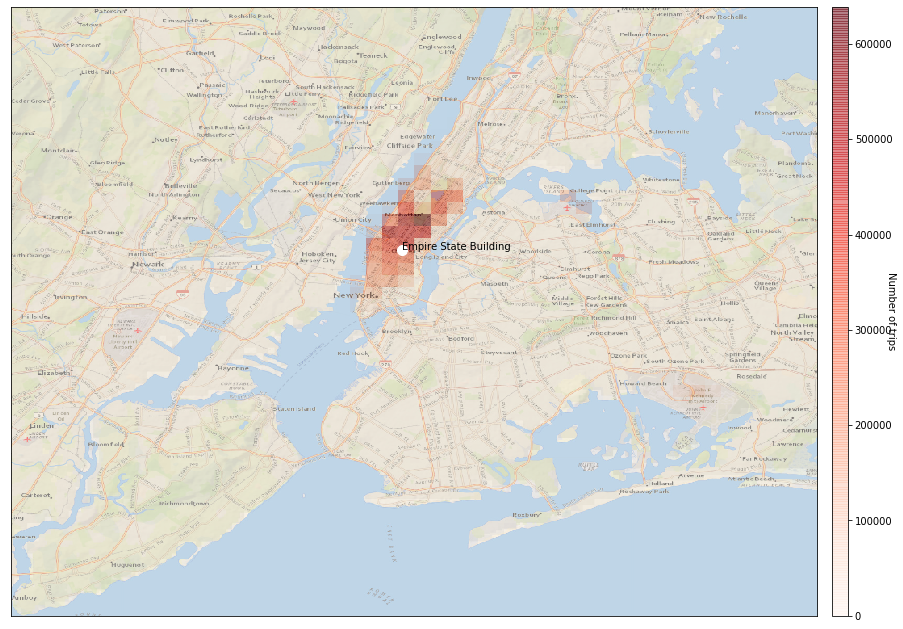

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
# setup mercator map projection.
m = Basemap(llcrnrlon=NY_x0,llcrnrlat=NY_y0,urcrnrlon=NY_x1,urcrnrlat=NY_y1,\
            resolution='h',projection='cyl',\
            lat_0=(NY_y0+NY_y1)/2,lon_0=(NY_x0+NY_x1)/2)

m.arcgisimage(service='NatGeo_World_Map', xpixels=1000, epsg=4269)

xpt, ypt = m(ESB_x, ESB_y)
m.plot(xpt, ypt, color='white', marker='o', markersize=10)
plt.text(xpt,ypt,'Empire State Building')

data = np.array(sum_data).reshape((50,50)).T
m.imshow(data, cmap='Reds', alpha=0.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Number of trips', rotation=270)
plt.show()

In [9]:
def get_geojson_grid(upper_right, lower_left, n=6):
    """Returns a grid of geojson rectangles, and computes the exposure in each section of the grid based on the vessel data.

    Parameters
    ----------
    upper_right: array_like
        The upper right hand corner of "grid of grids" (the default is the upper right hand [lat, lon] of the USA).

    lower_left: array_like
        The lower left hand corner of "grid of grids"  (the default is the lower left hand [lat, lon] of the USA).

    n: integer
        The number of rows/columns in the (n,n) grid.

    Returns
    -------

    list
        List of "geojson style" dictionary objects   
    """

    all_boxes = []

    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            geo_json = {"type": "FeatureCollection",
                        "properties":{
                            "lower_left": lower_left,
                            "upper_right": upper_right
                        },
                        "features":[]}

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                }
            }

            geo_json["features"].append(grid_feature)

            all_boxes.append(geo_json)

    return all_boxes

In [12]:
m2 = folium.Map(location=[(NY_y0+NY_y1)/2,(NY_x0+NY_x1)/2], zoom_start = 11)
folium.Marker(location=[SoL_y,SoL_x], popup = "Statue of Liberty", icon=folium.Icon(color = 'gray')).add_to(m2)
data = np.array(mean_data).reshape((50,50)).T
grid = get_geojson_grid([NY_y0, NY_x0], [NY_y1, NY_x1] , n=50)

norm = mpl.colors.Normalize(vmin=mean_data.min()[0], vmax=mean_data.max()[0])
cmap = mpl.cm.get_cmap('Reds')

for i, geo_json in enumerate(grid):

    color = cmap(norm(mean_data['trips'][i // 50 + 50*(i%50)]))
    color = mpl.colors.to_hex(color)

    gj = folium.GeoJson(geo_json,
                        style_function=lambda feature, color=color: {
                                                                        'fillColor': color,
                                                                        'color':"black",
                                                                        'weight': 1,
                                                                        'dashArray': '5, 5',
                                                                        'fillOpacity': 0.55,
                                                                    })
    
    
    if mean_data['trips'][i // 50 + 50*(i%50)] >= 5:
        m2.add_child(gj)
    
m2

In [13]:
print('Количество ячеек, в которых количество поездок в час в среднем не меньше 5:', mean_data.loc[mean_data['trips']>=5].shape[0])

Количество ячеек, в которых количество поездок в час в среднем не меньше 5: 102
